In [1]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.assignment_models as Models
import core
import keras
import tensorflow as tf
import os


PLOTS_DIR = f"plots/toponium_transformer_high_level_features/"
MODEL_DIR = f"models/toponium_transformer_high_level_features/"
CONFIG_PATH = "../config/workspace_config_high_level_features.yaml"

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)


load_config = get_load_config_from_yaml(CONFIG_PATH)

DataProcessor = DataPreprocessor(load_config)


with open(CONFIG_PATH, "r") as file:
    data_configs = yaml.safe_load(file)
plt.rcParams.update({"font.size": 14})

data_config = DataProcessor.load_from_npz(
    data_configs["npz_datapath"]["toponium"]
)
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.1)
del DataProcessor

2025-11-21 10:58:42.287256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763719122.311759  382178 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763719122.319808  382178 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763719122.339243  382178 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763719122.339269  382178 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763719122.339271  382178 computation_placer.cc:177] computation placer alr

In [2]:
reload(Models)
reload(core)
TransformerMatcher = Models.FeatureConcatTransformer(data_config, name="ToponiumTransformer")

TransformerMatcher.build_model(
    hidden_dim=64,
    num_layers=6,
    num_heads=8,
    dropout_rate=0.1
)

TransformerMatcher.adapt_normalization_layers(X_train)
#TransformerMatcher.load_model(MODEL_DIR + "model.keras")

TransformerMatcher.compile_model(
    loss={
        "assignment": core.utils.AssignmentLoss(lambda_excl=0.0),
    },
    optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    metrics={
        "assignment": [core.utils.AssignmentAccuracy()],
    },
)

FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.


I0000 00:00:1763719167.654531  382178 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Building model without regression output.


In [3]:
TransformerMatcher.train_model(
    epochs=100,
    X_train=X_train,
    y_train=y_train,
    sample_weights=core.utils.compute_sample_weights(X_train, y_train),
    batch_size=1024,
)

Epoch 1/100


I0000 00:00:1763719187.812559  383826 service.cc:152] XLA service 0x7f917000f380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763719187.812599  383826 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-11-21 10:59:48.404412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-21 10:59:49.079589: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
I0000 00:00:1763719190.854103  383826 cuda_dnn.cc:529] Loaded cuDNN version 91500


   8/1073 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.0849 - loss: 0.0014 

I0000 00:00:1763719205.192387  383826 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1071/1073 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0819 - loss: 0.0010

2025-11-21 11:00:22.701228: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert


1073/1073 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0821 - loss: 0.0010

2025-11-21 11:00:39.384095: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-21 11:00:41.818879: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert


1073/1073 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.0822 - loss: 0.0010 - val_accuracy: 0.5038 - val_loss: 7.6141e-04
Epoch 2/100
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.4722 - loss: 8.0958e-04 - val_accuracy: 0.5639 - val_loss: 6.7815e-04
Epoch 3/100
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5411 - loss: 7.3461e-04 - val_accuracy: 0.6197 - val_loss: 6.3232e-04
Epoch 4/100
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5877 - loss: 6.8866e-04 - val_accuracy: 0.6536 - val_loss: 6.0649e-04
Epoch 5/100
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6215 - loss: 6.5699e-04 - val_accuracy: 0.6770 - val_loss: 5.8770e-04
Epoch 6/100
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6456 - loss: 6.3482e-04 - val_accuracy: 0.6988 - val_loss: 5.7244e-04
Epoch 7/100
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6638 - loss: 6.1837e-04 - val_accuracy: 0.7123 - val_loss: 5.6359e-04
Epoch 8/100
1073/1073 ━━━━━━━

In [4]:
#TransformerMatcher.save_model(MODEL_DIR + "model.keras")

In [5]:
import core.assignment_models.BaselineAssignmentMethods as BaselineMethods
import core.reconstruction as Evaluation

reload(Evaluation)
reload(BaselineMethods)
delta_r_assigner = BaselineMethods.DeltaRAssigner(
    data_config,
    use_nu_flows=True,
)
chi_square = BaselineMethods.ChiSquareAssigner(
    data_config,
    use_nu_flows=True,
    use_nu_flows_for_assignment=True,
    top_mass=173.5e3,
)


ground_truth_assigner = Evaluation.GroundTruthReconstructor(
    data_config, name=r"True Assignment + $\nu^2$-Flows", use_nu_flows=True
)
evaluator = Evaluation.ReconstructionEvaluator(
    [
        ground_truth_assigner,
        chi_square,
        TransformerMatcher,
    ],
    X_val,
    y_val,
)

2025-11-21 11:29:15.254822: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert



Computing bootstrap confidence intervals...
True Assignment + $\nu^2$-Flows: Ground Truth (skipping)
$\chi^2$-Method ($\nu^2$-Flows): 0.4606 [0.4588, 0.4627]
ToponiumTransformer: 0.7813 [0.7793, 0.7834]


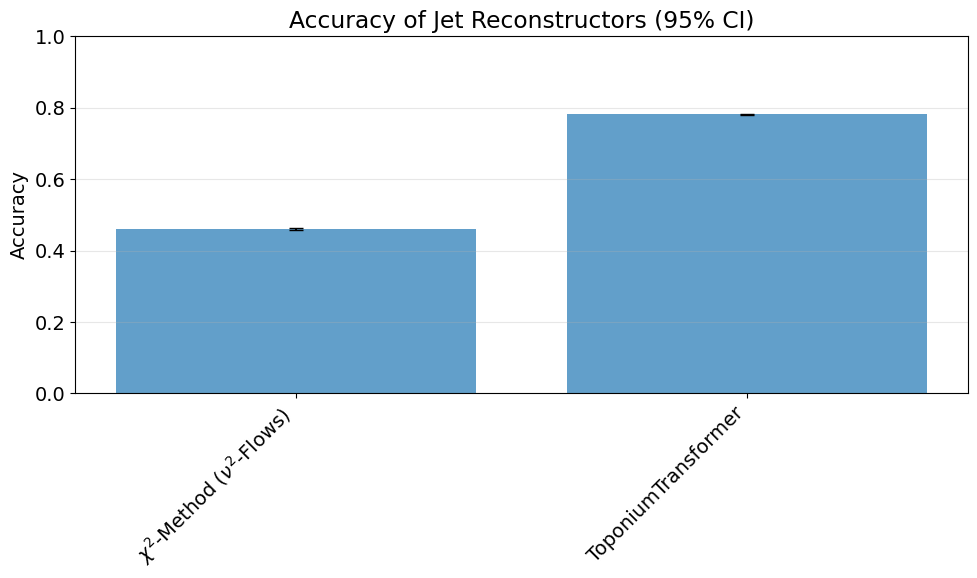

In [6]:
fig, ax = evaluator.plot_all_accuracies()
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing binned top mass resolution for truth_ttbar_mass...


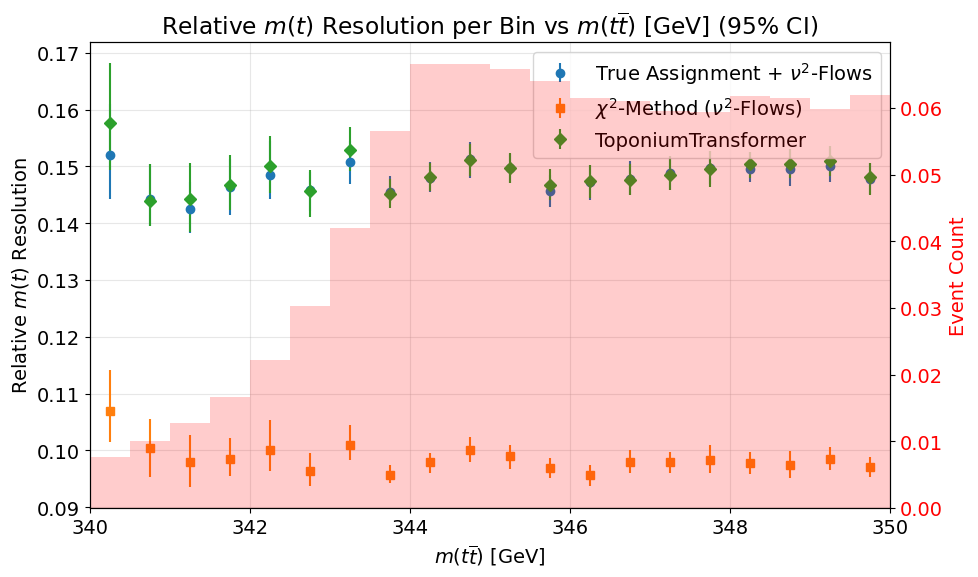

In [7]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=[340e3, 350e3],
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 350e3)
fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")


Computing binned ttbar mass resolution for truth_ttbar_mass...


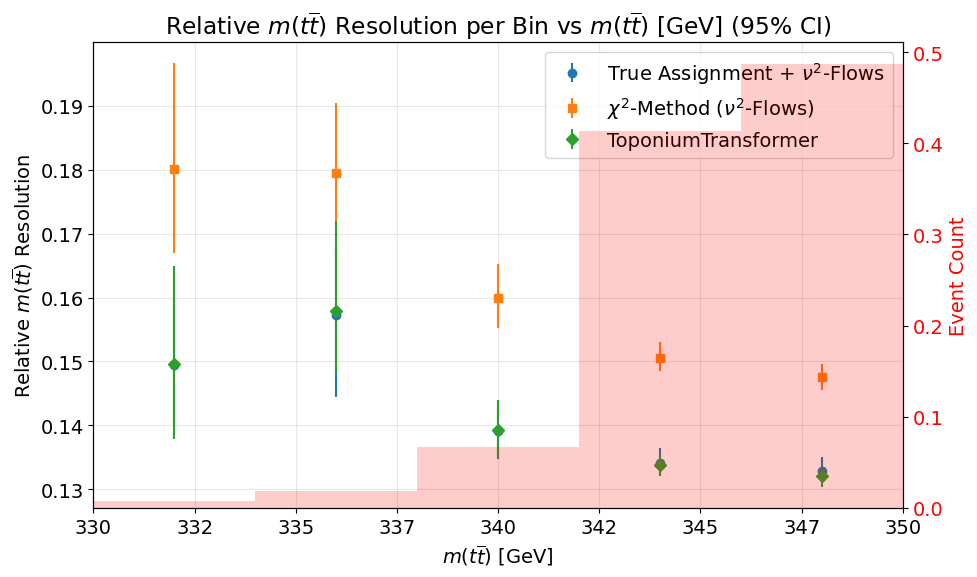

In [8]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    bins=5,
    xlims=(330e3, 350e3)
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")


Computing binned accuracy for truth_ttbar_mass...


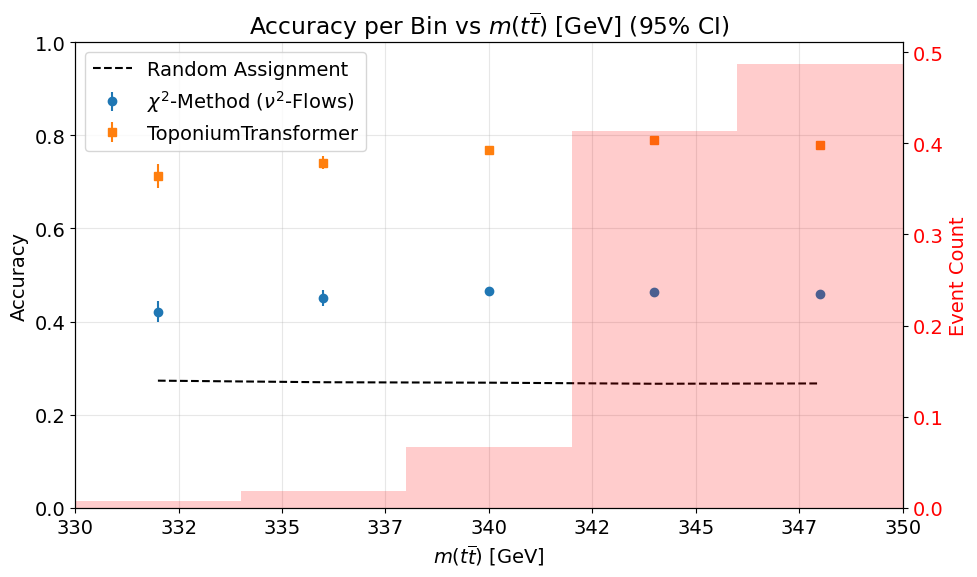

In [9]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    bins=5,
    xlims=(330e3, 350e3)
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")


Computing binned accuracy for N_jets...


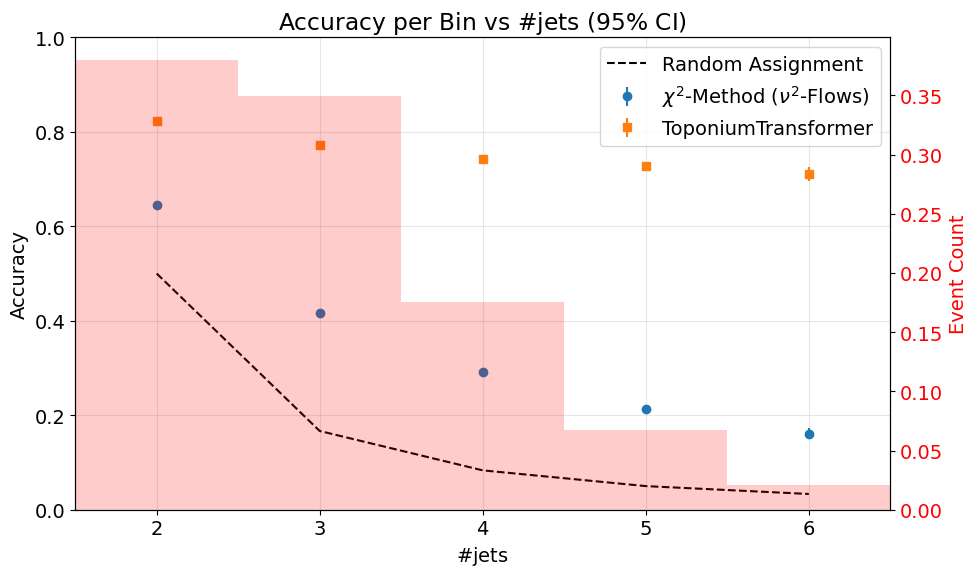

In [10]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_configs["LoadConfig"]["max_jets"] + 1),
    bins=data_configs["LoadConfig"]["max_jets"] - 1,
)
ax.set_xticks([i + 0.5 for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
ax.set_xticklabels([i for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")

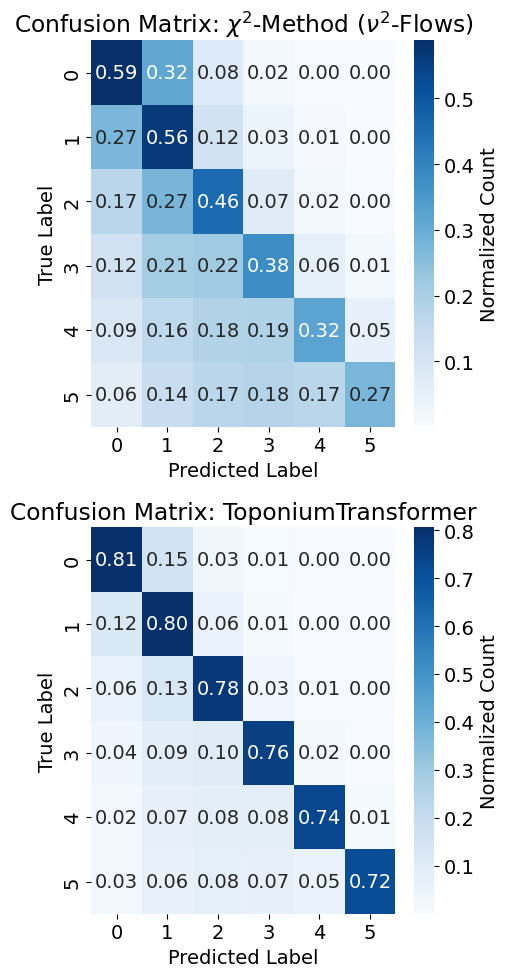

In [11]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

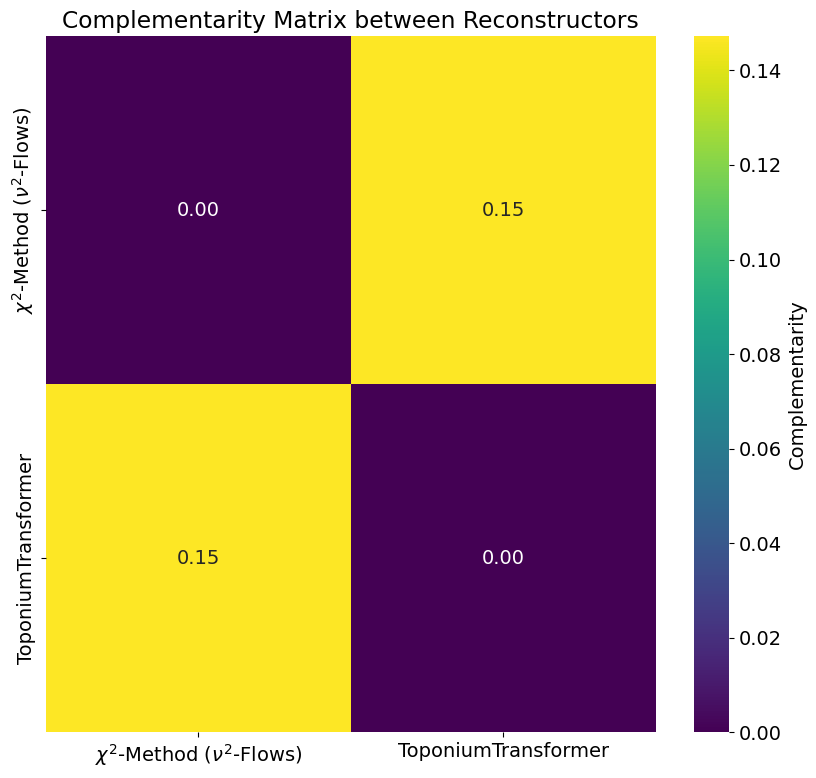

In [12]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(8.5, 8))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")